OBSERVATIONS

g:  3x120s\
r:  3x120s\
i:  3x120s\
Ha: 1x900s + 4x300s\
Hb: 4x1200s

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from matplotlib.patches import Circle

import glob
from astropy.io import fits
from matplotlib.colors import LogNorm

from photutils.background import (Background2D, MedianBackground)  # For estimating the background
from photutils.background import BkgZoomInterpolator               # For interpolating the background
from astropy import stats as astrostats

import gc

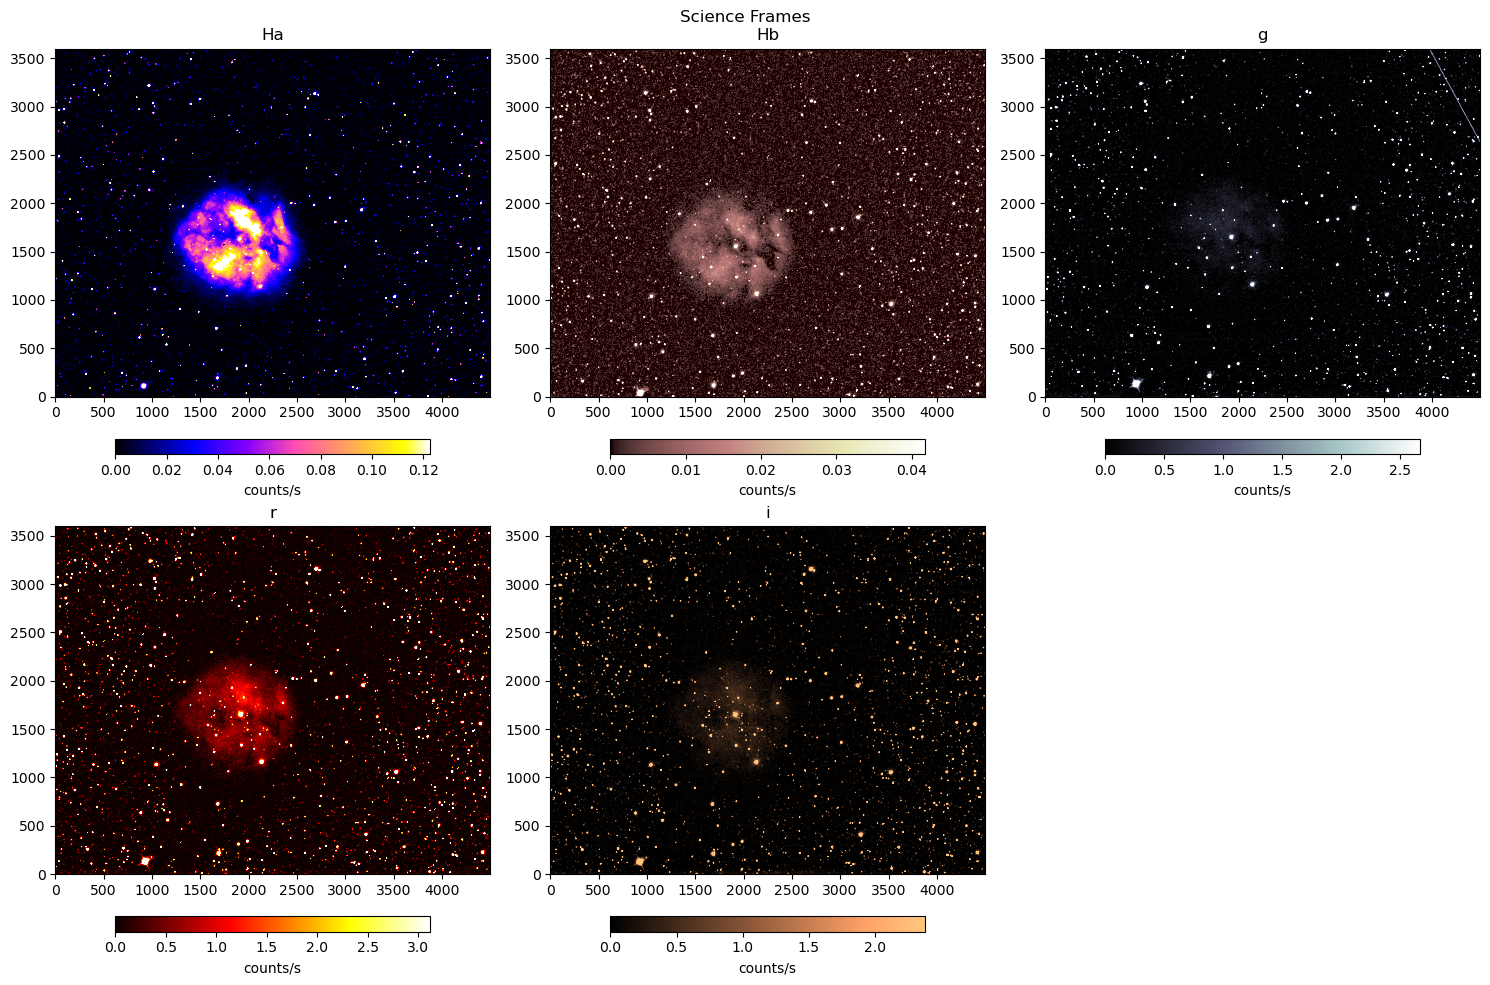

In [2]:
filters = ['Ha', 'Hb', 'g', 'r', 'i']
file_paths = {f: f'science_frames/{f}_filter_science.fit' for f in filters}

filter_cmap = {
    'Ha': 'gnuplot2',
    'Hb': 'pink',
    'g': 'bone',
    'r': 'hot',
    'i': 'copper'
}

filter_obs_time = {
    'Ha': 900,
    'Hb': 4800,
    'g': 120,
    'r': 120,
    'i': 120
}


filter_data = {name: fits.getdata(path) for name, path in file_paths.items()}
for name in filters:
    filter_data[name] = filter_data[name] / filter_obs_time[name]  # Normalize using the dictionary


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Science Frames")
axes = axes.flatten()

for i, name in enumerate(filters):
    cmap = filter_cmap[name]  # Access the colormap using the dictionary
    im = axes[i].imshow(filter_data[name], clim=[0, np.quantile(filter_data[name], 0.99)], cmap=cmap, origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    axes[i].set_title(name)

axes[-1].axis('off')

plt.tight_layout()
plt.show()



## Dithering

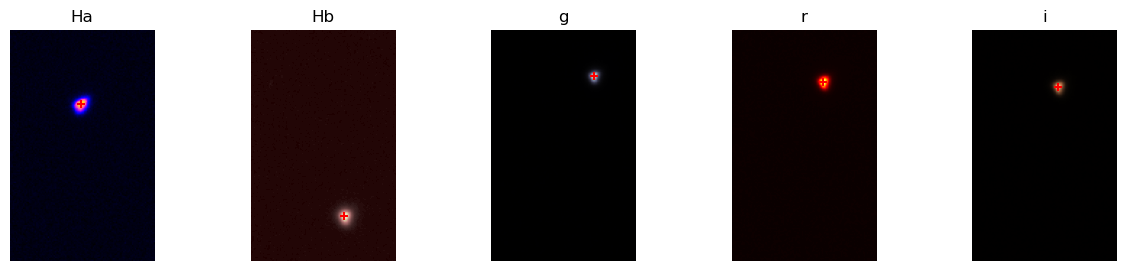

In [3]:
from photutils.centroids import centroid_quadratic

star_centroid = []

x_sx = 2850
x_dx = 2950
y_sx = 1700
y_dx = 1860

fig, ax = plt.subplots(1, 5, figsize=(15, 3))  # Create 1x5 grid

for i, name in enumerate(filters):
    rectangle = filter_data[name][y_sx:y_dx, x_sx:x_dx]

    #print(np.max(rectangle))
    #max_coords = np.unravel_index(np.argmax(rectangle), rectangle.shape)
    #print("Coordinates of max value:", max_coords)
    
    # Calculate centroid
    centroid = centroid_quadratic(rectangle)
    star_centroid.append(centroid)
    
    # Plot rectangle
    im = ax[i].imshow(rectangle, cmap=filter_cmap[name], origin='lower', aspect='equal')
    ax[i].scatter(centroid[0], centroid[1], marker='+', color='red')  # Mark centroid
    ax[i].set_title(name)
    ax[i].axis("off")


In [4]:
print(star_centroid)
offsets = np.round(star_centroid[0] - star_centroid).astype(int) # refered to first exposure 
print(offsets)

[array([ 48.51851157, 108.31249711]), array([64.2946058 , 30.71136048]), array([ 70.64060219, 127.68554853]), array([ 62.57858364, 123.62795359]), array([ 59.1364272 , 120.24000556])]
[[  0   0]
 [-16  78]
 [-22 -19]
 [-14 -15]
 [-11 -12]]


In [5]:
filters_aligned = {}

for i, name in enumerate(filters):
    
    aligned_filter = np.roll(filter_data[name], (offsets[i, 0], offsets[i, 1]), axis=(1, 0))
    filters_aligned[name] = aligned_filter  # Store aligned filter in the dictionary
#del filter_data 
#gc.collect();

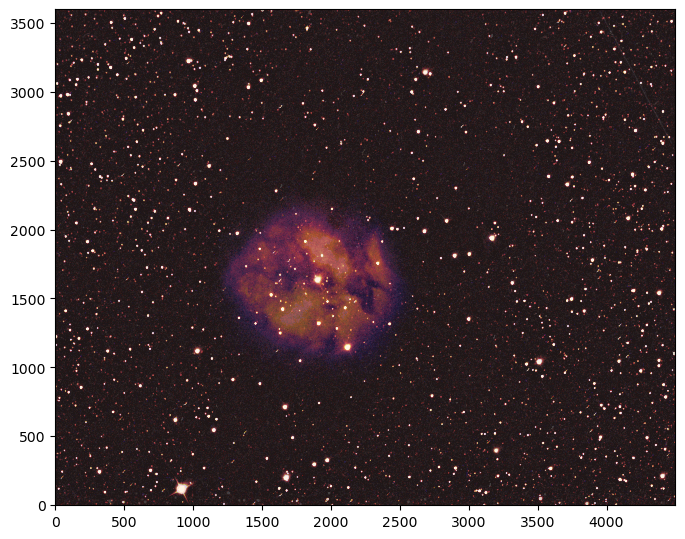

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

alpha = [0.6, 0.4, 0.2, 0.4,0.2]#,0.3, 0.3, 0.3]
selected_filters = ['Ha','Hb','g', 'r', 'i']  # Ensure these align with alpha

for i, name in enumerate(selected_filters):  # Use enumerate to align with alpha
    im1 = ax.imshow(filters_aligned[name], clim=[0, np.quantile(filters_aligned[name], 0.99)], 
                    cmap=filter_cmap[name], origin='lower', alpha=alpha[i], aspect='equal')

plt.show()


## CALIBRATION

Although SDSS (or other surveys) dispaly ugriz filter data, filters on TOBI are most probably different, because of different trasmission of the filter and also different response of the detector to different wavelength (different quantum efficiency). Different trasmission result in different pivotal wavelength (the pivotal wavelenght is determined by the shape of the filter)

$$\lambda_p = \sqrt{\frac{\int \lambda T(\lambda) \, d\lambda}{\int \frac{T(\lambda)}{\lambda} \, d\lambda}}$$

$$f_{\lambda,V}\approx \frac{\int d\lambda T(\lambda)f(\lambda)}{\int d\lambda T(\lambda)}$$

it's a covolution, weighting. Important: two filters with the same centroid but different bandwidth or different heights will give the same specific flux $f_\lambda$. Of course the broader filter, or the higher, will give higher electron count rate ans so higher SNR.


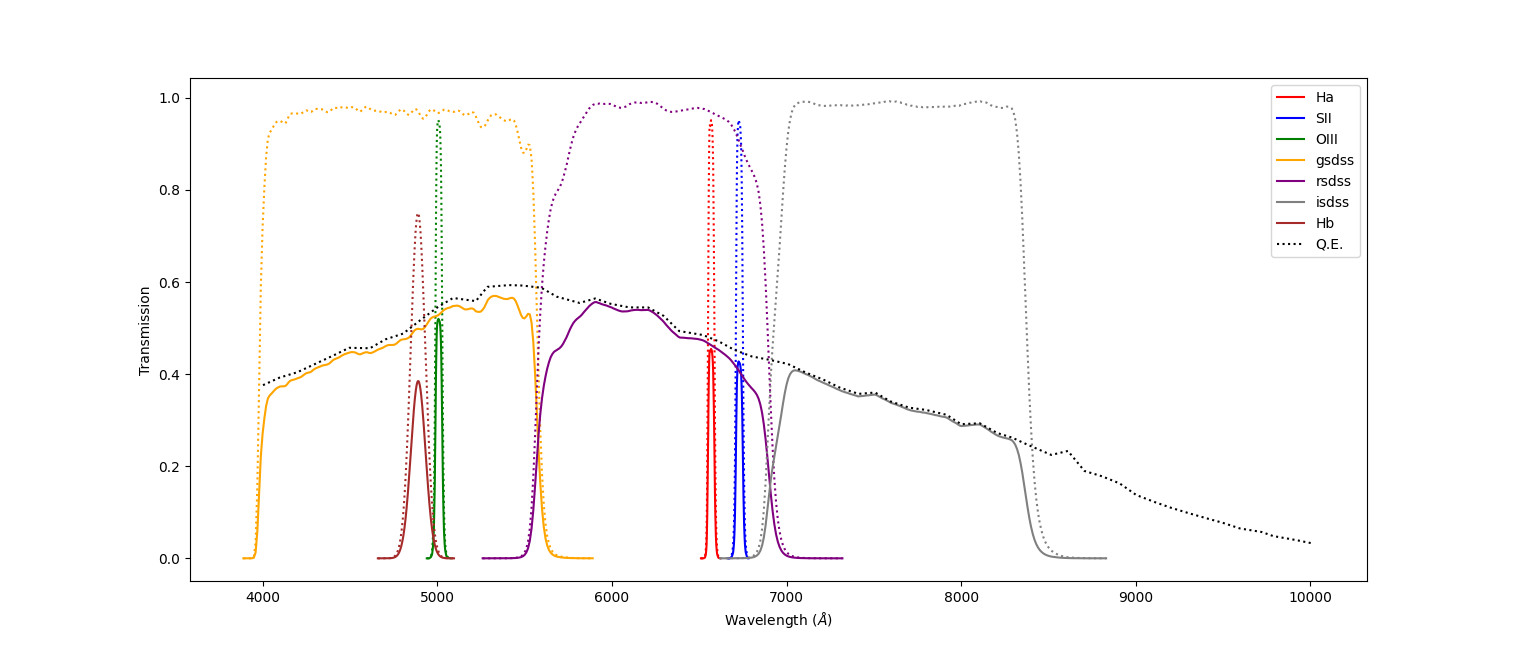

### Filter color transformations

TOBI_ha = SDSS_r -0.2568 * (SDSS_g-SDSS_r) + 0.1470

TOBI_hb =  SDSS_g -0.2322 * (SDSS_g-SDSS_r) + -0.0024

TOBI_g   = SDSS_g -0.1205 * (SDSS_g-SDSS_r) + 0.0012

TOBI_r    = SDSS_r -0.0061 * (SDSS_g-SDSS_r) + 0.0001

TOBI_i    = SDSS_i -0.0609 * (SDSS_r-SDSS_i) + 0.0049

In [8]:
def TOBI_Ha(sdss_r,sdss_g):
    return sdss_r - 0.2568 * (sdss_g - sdss_r) + 0.1470

def TOBI_Hb(sdss_r,sdss_g):
    return sdss_g - 0.2322 * (sdss_g - sdss_r) - 0.0024

def TOBI_g(sdss_r,sdss_g):
    return sdss_g - 0.1205 * (sdss_g - sdss_r) + 0.0012

def TOBI_r(sdss_r,sdss_g):
    return sdss_r - 0.0061 * (sdss_g - sdss_r) + 0.0001

def TOBI_i(sdss_r,sdss_i):
    return sdss_i - 0.0609 * (sdss_r - sdss_i) + 0.0049


In [9]:
# Stars recognized by ASTROMETRY.NET  https://nova.astrometry.net/upload
# x,y coordinates on detector and ra dec coordinates 

file_path = "data/image-radec.fits"

with fits.open(file_path) as hdul:
    #hdul.info()                        # Display information about the FITS file content
    # Access and print the Primary HDU (Header Data Unit)
    primary_hdu = hdul[0]  # The first HDU
    #print("\nPrimary HDU Header:")
    #print(repr(primary_hdu.header))  # Print the header in detail
    
    # If the second HDU is a table, print its contents
    if len(hdul) > 1:
        table_hdu = hdul[1]  # The second HDU
        #print("\nTable HDU Data (First 5 Rows):")
        #print(table_hdu.data[:3])  # Print the first 5 rows of the table

        if table_hdu.data.ndim == 1:
            table = np.stack(table_hdu.data)

        stars_ra = table[:,0]
        stars_dec = table[:,1]
        stars_x = table[:,2]
        stars_y = table[:,3]



In [10]:
# stars in the field from SDSS catalogue

file_path = "/home/robertoinfurna/Downloads/asu(5).fit"

with fits.open(file_path) as hdul:
    #hdul.info()                        # Display information about the FITS file content
    # Access and print the Primary HDU (Header Data Unit)
    primary_hdu = hdul[0]  # The first HDU
    #print("\nPrimary HDU Header:")
    #print(repr(primary_hdu.header))  # Print the header in detail
    
    # If the second HDU is a table, print its contents
    if len(hdul) > 1:
        table_hdu = hdul[1]  # The second HDU
        #print("\nTable HDU Data (First 5 Rows):")
        #print(table_hdu.data[:3])  # Print the first 5 rows of the table

        sdss_stars_ra = table_hdu.data['RA_ICRS']
        sdss_stars_dec = table_hdu.data['DE_ICRS']
        sdss_stars_rmag = table_hdu.data['rmag']
        sdss_stars_gmag = table_hdu.data['gmag']
        sdss_stars_imag = table_hdu.data['imag']
        
        #print(table_hdu.data['umag'])

        #print(len(table_hdu.data))

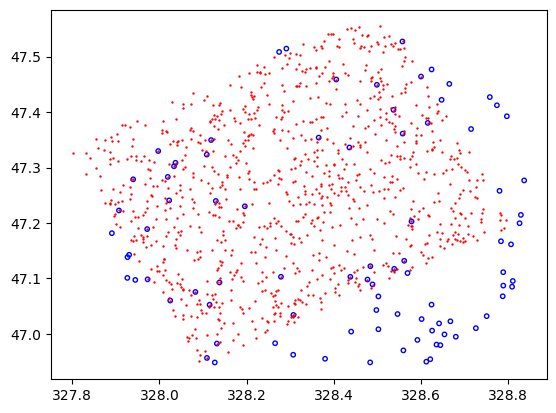

In [11]:
plt.scatter(sdss_stars_ra,sdss_stars_dec,edgecolors='blue', facecolors='none', s=10)
plt.scatter(stars_ra,stars_dec,c='r',s=0.5)

In [24]:
# select those stars present both in astrometry.net and in sdss

stars_calib = []  # This will store the list of stars with all properties

#create aperture to measure the counts/s of each star

from photutils.aperture import CircularAperture, aperture_photometry
from photutils.centroids import centroid_com
from astropy.modeling import models, fitting

# centroid_com (Center of Mass): 
# Uses the weighted average of pixel intensities.
# Assumes the brightest part of the image corresponds to the object's center.
# Sensitive to noise and nearby objects but works well for symmetric and isolated stars.

# centroid_quadratic:
# Fits a 2D quadratic function (paraboloid) to the pixel intensities around the peak.
# Finds the peak position analytically based on the quadratic fit.
# More accurate for well-sampled peaks, but requires the peak to be well-defined and isolated.



# Loop through each star
for i in range(len(stars_x)):  # Loop over the stars in your image
    for j in range(len(sdss_stars_ra)):  # Loop over the SDSS stars
        # Match RA/Dec with a tolerance
        if np.isclose(stars_ra[i], sdss_stars_ra[j], atol=1e-5, rtol=1e-6) and \
           np.isclose(stars_dec[i], sdss_stars_dec[j], atol=1e-5, rtol=1e-6):
            #print(f"Matched RA: {stars_ra[i]} with SDSS RA: {sdss_stars_ra[j]}")
            #print(f"Matched Dec: {stars_dec[i]} with SDSS Dec: {sdss_stars_dec[j]}")


            photometry = {}  
            
            for name in filters:  

                # Determine the centroids of the stars (more accurate than the astrometry.net ones)
                l = 20  # Length of the region around the star to extract
                # Extract the rectangle around the star from the image
                rectangle = filters_aligned[name][int(stars_y[i] - l):int(stars_y[i] + l), 
                                                int(stars_x[i] - l):int(stars_x[i] + l)]
                    
                # Compute the centroid of the star within the cutout
                #centroid_y, centroid_x = centroid_com(rectangle)
                    
                # Adjust the centroid to the full image coordinates
                #refined_y = stars_y[i] - l + centroid_y
                #refined_x = stars_x[i] - l + centroid_x
                    
                # Fit a 2D Gaussian to the cutout
                y, x = np.mgrid[:rectangle.shape[0], :rectangle.shape[1]]
                g_init = models.Gaussian2D(amplitude=rectangle.max(), x_mean=l, y_mean=l, x_stddev=5, y_stddev=5)
                fit = fitting.LevMarLSQFitter()
                g_fit = fit(g_init, x, y, rectangle)
            
                # Extract the refined position from the Gaussian fit
                refined_x = stars_x[i] - l + g_fit.x_mean.value
                refined_y = stars_y[i] - l + g_fit.y_mean.value
                    
                # Extract sigma values and calculate FWHM
                sigma_x, sigma_y = g_fit.x_stddev.value, g_fit.y_stddev.value
                fwhm_x = 2.355 * sigma_x
                fwhm_y = 2.355 * sigma_y
                    
                # Optionally, average FWHM
                fwhm = (fwhm_x + fwhm_y) / 2
            
                # Create a CircularAperture object with a radius of 1 times the FWHM
                # Why 1 times the FWHM? This is a common choice to include most of the star's light.
                aperture = CircularAperture((refined_x, refined_y), r = 3 * fwhm)
            
                # Perform aperture photometry for the current filter
                phot_table = aperture_photometry(filters_aligned[name], aperture)   

                photometry[name] = {
                    'counts_s': phot_table['aperture_sum'][0],  # Flux
                    'centroid': (refined_x, refined_y),         # Refined centroid
                    'aperture': 3  * fwhm,                      # photomoetric aperture is 3 times the FWHM
                }

            
            # Append a dictionary with all the properties
            stars_calib.append({
                'x': stars_x[i],
                'y': stars_y[i],
                'ra': stars_ra[i],
                'dec': stars_dec[i],
                'sdss_ra': sdss_stars_ra[j],
                'sdss_dec': sdss_stars_dec[j],
                'rmag': sdss_stars_rmag[j],  # Assuming `sdss_stars_rmag` is the r-band magnitude of the SDSS star
                'gmag': sdss_stars_gmag[j],  # Assuming `sdss_stars_umag` is the u-band magnitude
                'imag': sdss_stars_imag[j],  # Assuming `sdss_stars_imag` is the i-band magnitude
                'true_mag_tobi': {
                        'Ha': TOBI_Ha(sdss_stars_rmag[j],sdss_stars_gmag[j]),
                        'Hb': TOBI_Hb(sdss_stars_rmag[j],sdss_stars_gmag[j]),
                        'g': TOBI_g(sdss_stars_rmag[j],sdss_stars_gmag[j]),
                        'r': TOBI_r(sdss_stars_rmag[j],sdss_stars_gmag[j]),
                        'i': TOBI_i(sdss_stars_rmag[j],sdss_stars_imag[j])
                    },
                'photometry': photometry
                
            })
            

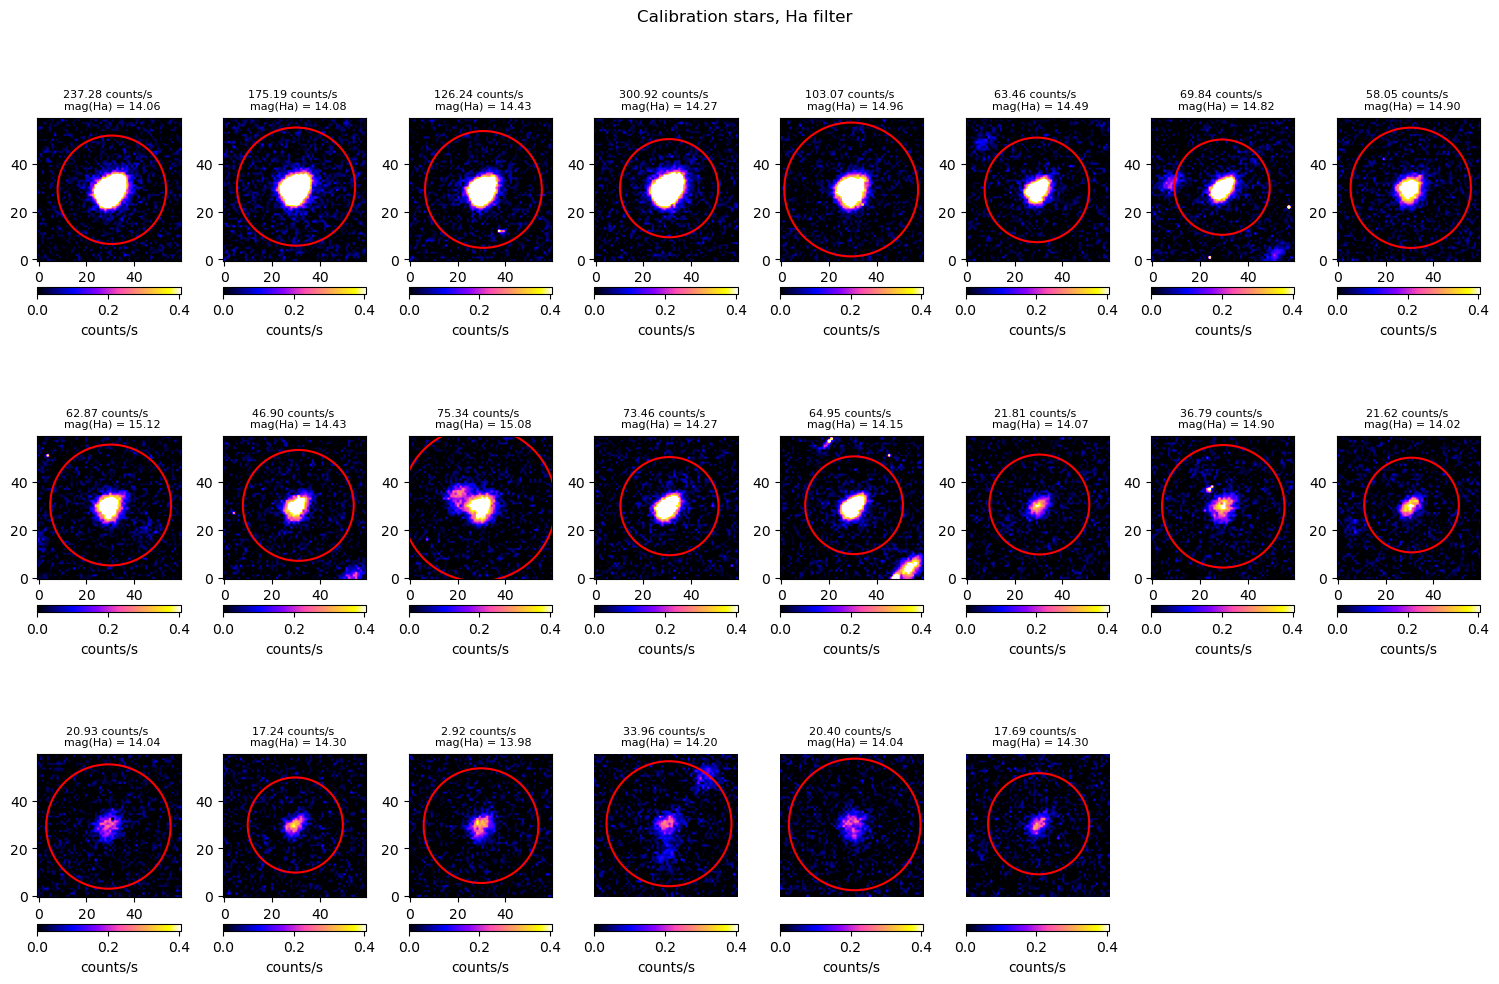

In [41]:
N = len(stars_calib)

filter_name = 'Ha'

cmax = np.quantile(filters_aligned[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()


cmax = np.quantile(filters_aligned[filter_name],0.999)

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = filters_aligned[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}\n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_tobi'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()


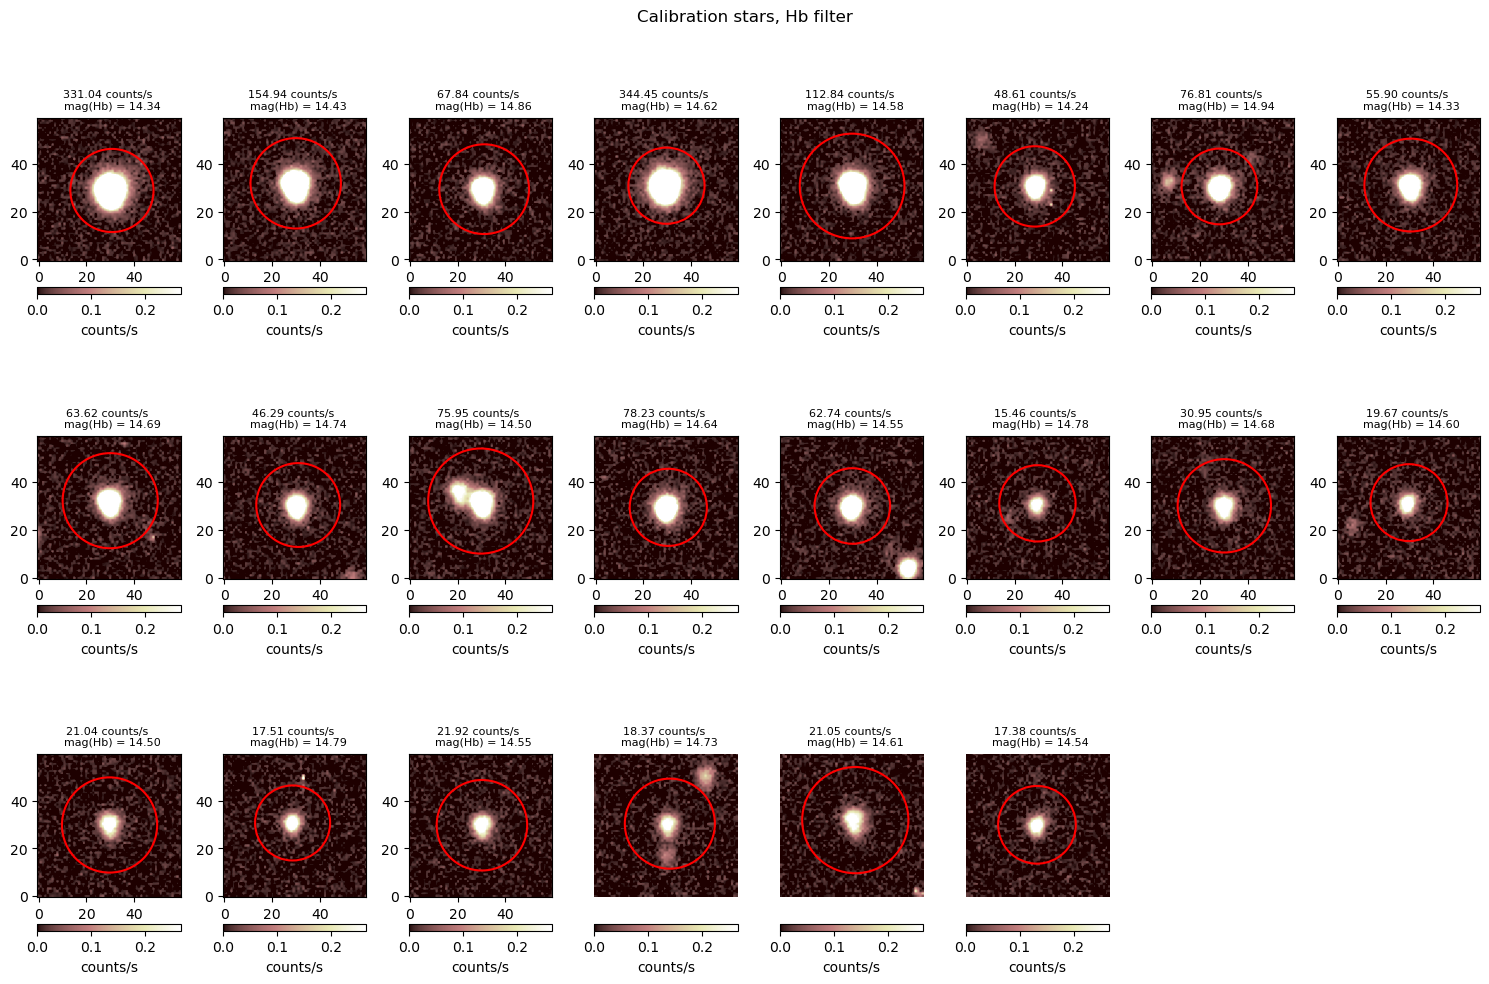

In [42]:
N = len(stars_calib)

filter_name = 'Hb'

cmax = np.quantile(filters_aligned[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()


cmax = np.quantile(filters_aligned[filter_name],0.999)

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = filters_aligned[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}\n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_tobi'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()

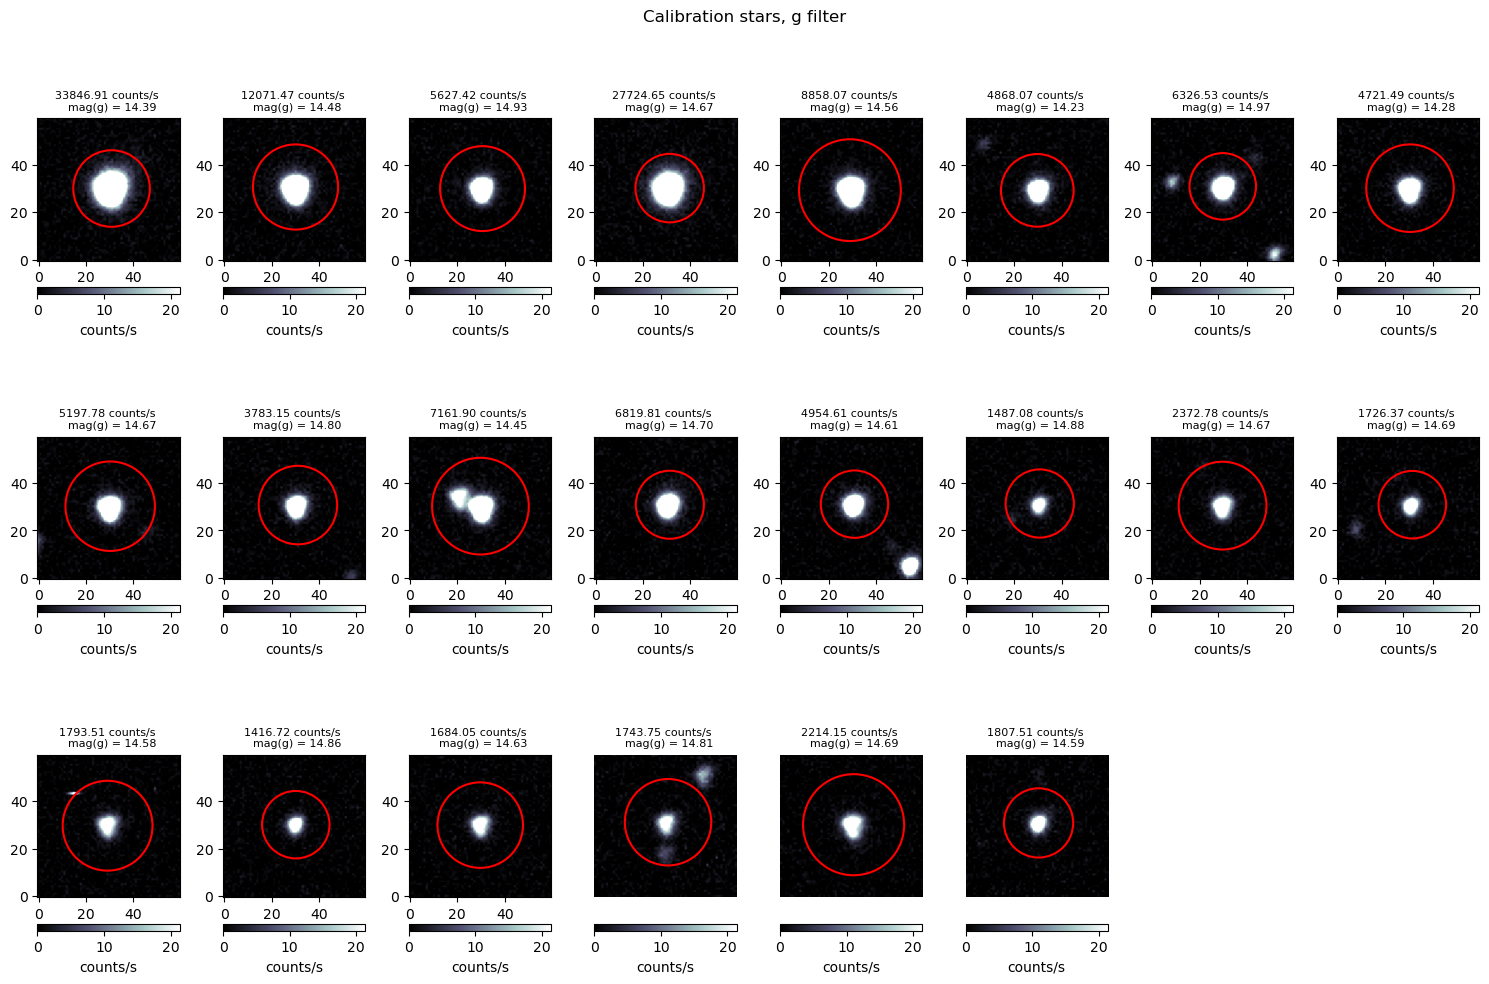

In [43]:
N = len(stars_calib)

filter_name = 'g'

cmax = np.quantile(filters_aligned[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()


cmax = np.quantile(filters_aligned[filter_name],0.999)

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = filters_aligned[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}\n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_tobi'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()



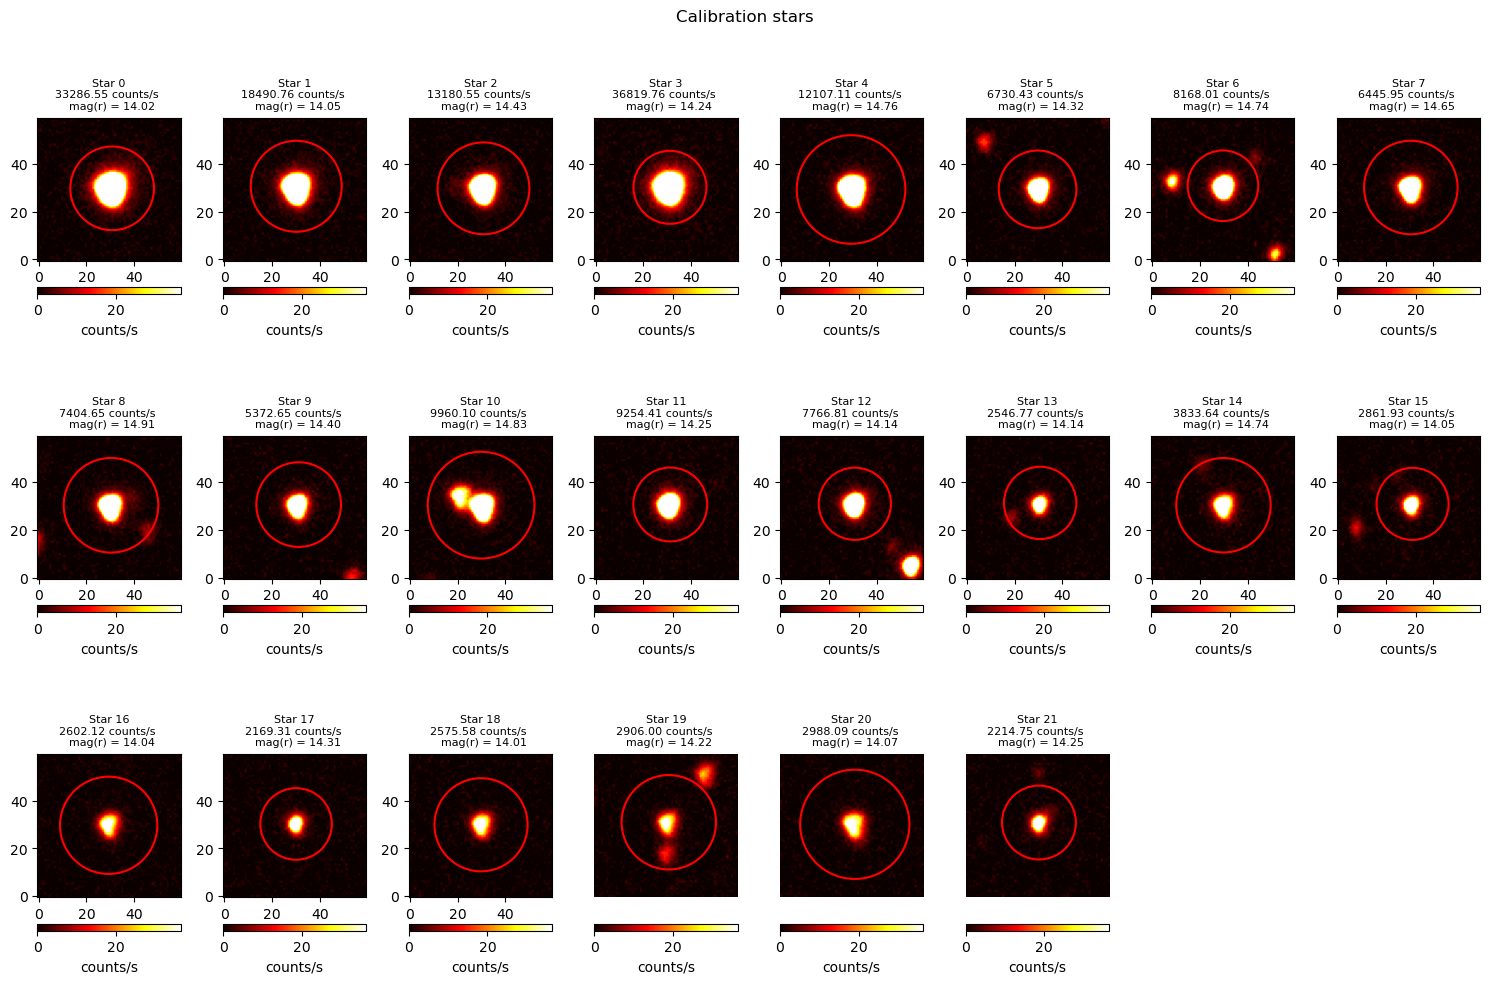

In [31]:
N = len(stars_calib)

filter_name = 'r'

cmax = np.quantile(filters_aligned[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = filters_aligned[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}\n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_tobi'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()


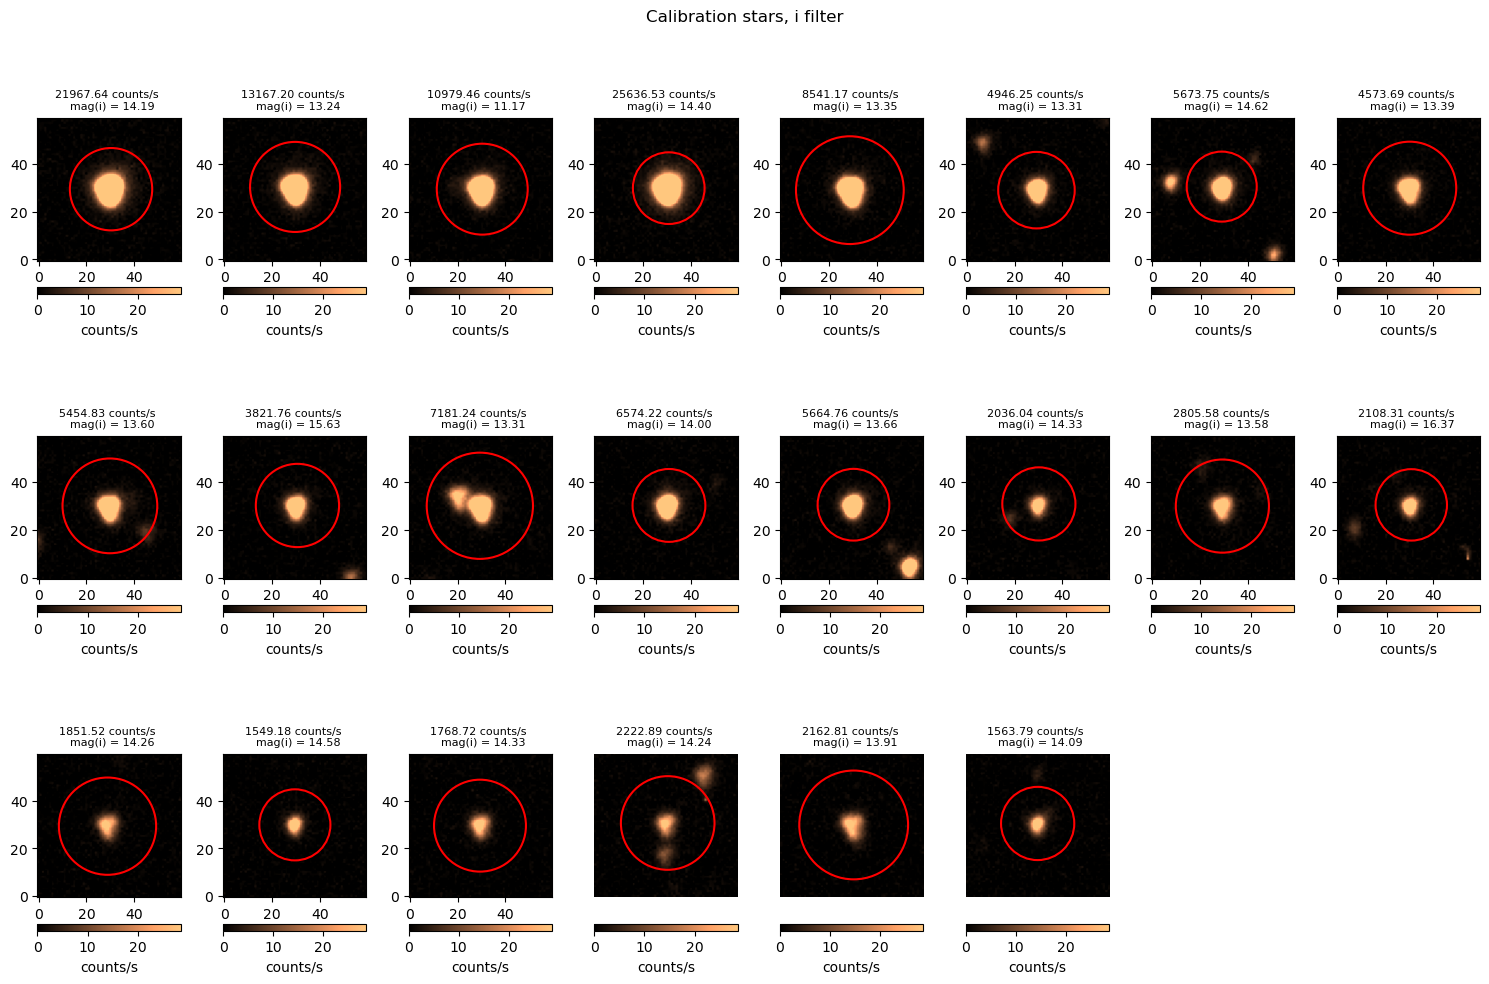

In [44]:
N = len(stars_calib)

filter_name = 'i'

cmax = np.quantile(filters_aligned[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()


cmax = np.quantile(filters_aligned[filter_name],0.999)

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = filters_aligned[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}\n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_tobi'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()

**INSTRUMENTAL RESPONSE**

C depends on the instrument and on the FILTER. It changes with time, mainly because of dust. Converts a flux in erg/cm^2s^2A^2 in electron per second rate. Analogic digital converter then gives DU. C is called ZERO POINT. 

$$f_\lambda = 10^{-C} N_e$$   integrated over the band

taking the log and multiplying left and right by -2.5:

$$-2.5\log(f_\lambda) = 2.5C - 2.5\log(N_e)$$

the term on left is the apparent magnitude of the source (real flux), while the first term on right is referred to as "zero point" and the second term as instrument magnitude:

$$m_{true} = Z.P. + m_i$$

Specific fluxes conversion: $F_\lambda d\lambda = F_\nu d\nu$ and $\nu\lambda = c$ gives $F_\lambda = F_\nu c/\lambda^2$ 

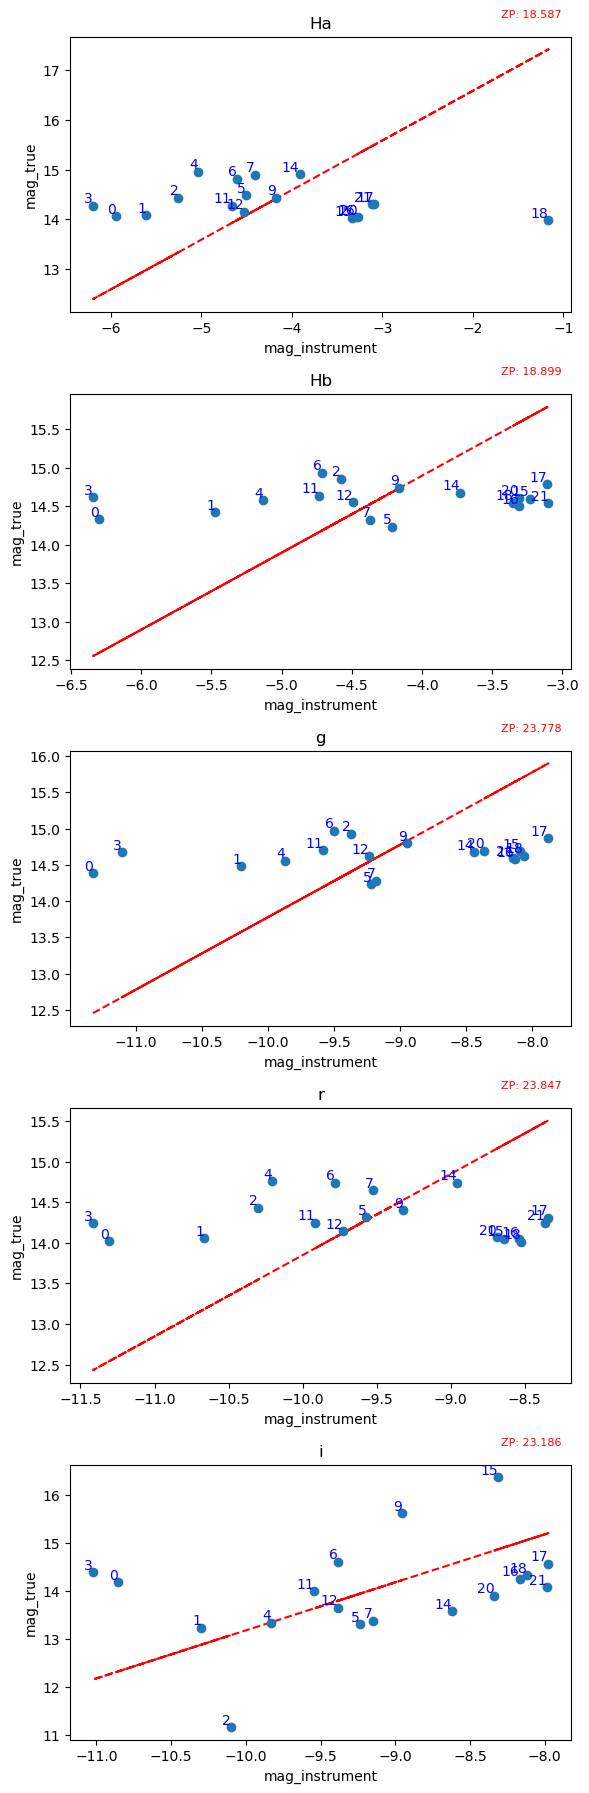

In [52]:
from scipy.stats import linregress

# Extract rmag values from stars_calib

fig, ax = plt.subplots(5,1,figsize=(6, 18))

# Stars to exclude
exclude_indexes = {8,10,13,19}  

for i, name in enumerate(filters):
    ax[i].set_title(name)
    
    mag_true = [star['true_mag_tobi'][name] for star in stars_calib]
    counts_s = [star['photometry'][name]['counts_s'] for star in stars_calib]
    mag_instrument = -2.5 * np.log10(counts_s)
    
    # Plot data (excluding specific indexes)
    filtered_points = [(j, x, y) for j, (x, y) in enumerate(zip(mag_instrument, mag_true)) if j not in exclude_indexes]
    x_vals = np.array([x for _, x, _ in filtered_points])
    y_vals = np.array([y for _, _, y in filtered_points])


    # Compute linear fit
    #slope, intercept, _, _, _ = linregress(x_vals, y_vals)
    #fit_line = slope * x_vals + intercept

    intercept = np.mean(y_vals - x_vals)  # ZP = mean(y - x)
    fit_line = x_vals + intercept  # y = x + ZP
    
    # Plot linear fit line
    ax[i].plot(x_vals, fit_line, '--', color='red', label='Linear Fit')
    
    # Slope: {slope:.3f}\n
    text = f"ZP: {intercept:.3f}"
    ax[i].text(0.98, 1.1, text, fontsize=8, color='red',
               transform=ax[i].transAxes, ha='right', va='top')
    
    ax[i].plot(x_vals, y_vals, 'o')
    ax[i].set_xlabel('mag_instrument')
    ax[i].set_ylabel('mag_true')
 
    for j, x, y in filtered_points:
        ax[i].text(x, y, str(j), fontsize=10, color='blue', ha='right', va='bottom')

plt.tight_layout()
plt.show()


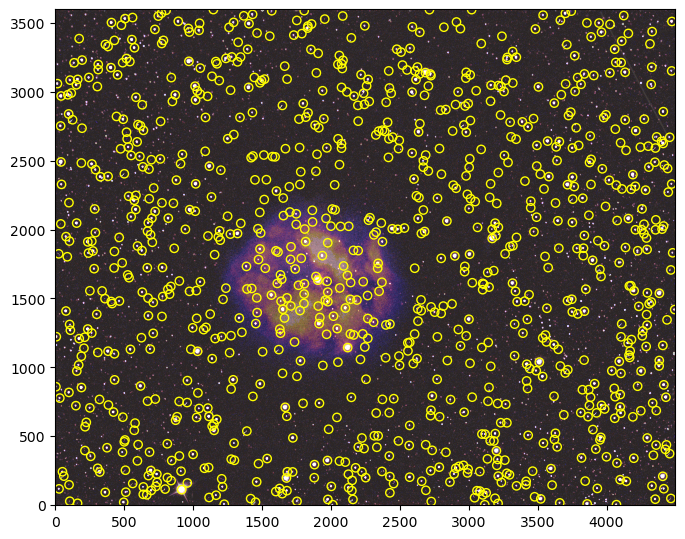

In [8]:
from scipy.optimize import least_squares

# Define the residual function to minimize
def residuals(params, x_pixels, y_pixels, ra_values, dec_values):
    CRPIX_x, CRPIX_y, CRVAL_RA, CRVAL_Dec, A, B, C, D = params
    ra_pred = CRVAL_RA + A * (x_pixels - CRPIX_x) + B * (y_pixels - CRPIX_y)
    dec_pred = CRVAL_Dec + C * (x_pixels - CRPIX_x) + D * (y_pixels - CRPIX_y)
    
    # Compute residuals between predicted and observed RA/Dec
    residual_ra = ra_pred - ra_values
    residual_dec = dec_pred - dec_values
    
    return np.concatenate([residual_ra, residual_dec])

# Initial guess for the parameters [CRPIX_x, CRPIX_y, CRVAL_RA, CRVAL_Dec, A, B, C, D]
params_initial_guess = [1000, 1000, 10, 10, 0.001, 0.001, 0.001, 0.001]

# Solve the least-squares problem
result = least_squares(residuals, params_initial_guess, args=(stars_x, stars_y, stars_ra, stars_dec))

# Extract the fitted parameters
CRPIX_x, CRPIX_y, CRVAL_RA, CRVAL_Dec, A, B, C, D = result.x

print("Fitted parameters:")
print(f"CRPIX_x = {CRPIX_x}, CRPIX_y = {CRPIX_y}")
print(f"CRVAL_RA = {CRVAL_RA}, CRVAL_Dec = {CRVAL_Dec}")
print(f"A = {A}, B = {B}, C = {C}, D = {D}")


# Assuming you already have the RA/Dec transformation coefficients
# Apply the transformation to get the RA/Dec grid for the image
image_height, image_width = filters_aligned['Ha'].shape
x_grid, y_grid = np.meshgrid(np.arange(image_width), np.arange(image_height))
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Apply RA/Dec transformation to the flattened pixel coordinates
ra_flat = CRVAL_RA + A * (x_flat - CRPIX_x) + B * (y_flat - CRPIX_y)
dec_flat = CRVAL_Dec + C * (x_flat - CRPIX_x) + D * (y_flat - CRPIX_y)

# Reshape RA/Dec back to the shape of the image
ra_grid = ra_flat.reshape((image_height, image_width))
dec_grid = dec_flat.reshape((image_height, image_width))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

selected_filters = ['Ha']
cmap = ['gnuplot2']
alpha = [1]
for i, name in enumerate(selected_filters):  # Use enumerate to align with alpha
    im1 = ax.imshow(filters_aligned[name], clim=[0, np.quantile(filters_aligned[name], 0.99)], 
                    cmap=cmaps[i], origin='lower', alpha=alpha[i], aspect='equal')

# Set RA/Dec as axis labels
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')

# Set the ticks for RA and Dec
ra_ticks = np.linspace(ra_grid.min(), ra_grid.max(), 5)
dec_ticks = np.linspace(dec_grid.min(), dec_grid.max(), 5)

# Update the axis ticks and labels
ax.set_xticks(np.linspace(0, image_width-1, len(ra_ticks)))
ax.set_yticks(np.linspace(0, image_height-1, len(dec_ticks)))
ax.set_xticklabels([f"{ra:.2f}" for ra in ra_ticks])
ax.set_yticklabels([f"{dec:.2f}" for dec in dec_ticks])


KeyError: 'Ha'

(array([51., 61., 45., 30., 24., 17., 10.,  7.,  7.,  6.,  2.,  3.,  2.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.        ,   2.04081633,   4.08163265,   6.12244898,
          8.16326531,  10.20408163,  12.24489796,  14.28571429,
         16.32653061,  18.36734694,  20.40816327,  22.44897959,
         24.48979592,  26.53061224,  28.57142857,  30.6122449 ,
         32.65306122,  34.69387755,  36.73469388,  38.7755102 ,
         40.81632653,  42.85714286,  44.89795918,  46.93877551,
         48.97959184,  51.02040816,  53.06122449,  55.10204082,
         57.14285714,  59.18367347,  61.2244898 ,  63.26530612,
         65.30612245,  67.34693878,  69.3877551 ,  71.42857143,
         73.46938776,  75.51020408,  77.55102041,  79.59183673,
         81.63265306,  83.67346939,  85.71428571,  87.75510204,
         89.79591

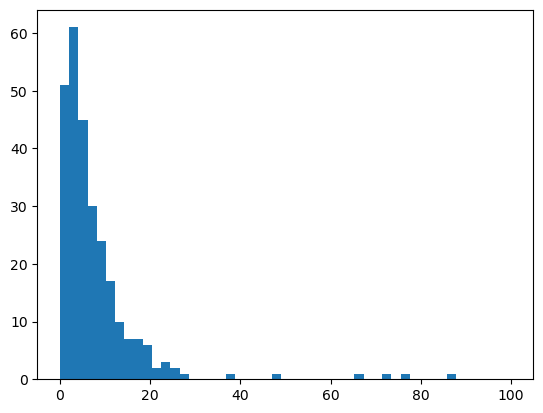

In [13]:
plt.hist(counts_s['r'],bins=np.linspace(0,100))

In [24]:
int(-2)

-2

In [13]:
print(min(stars_ra))
print(max(stars_ra))
print(min(stars_dec))
print(max(stars_dec))

327.80225889960883
328.80525132104617
46.94982498208212
47.570668917489606


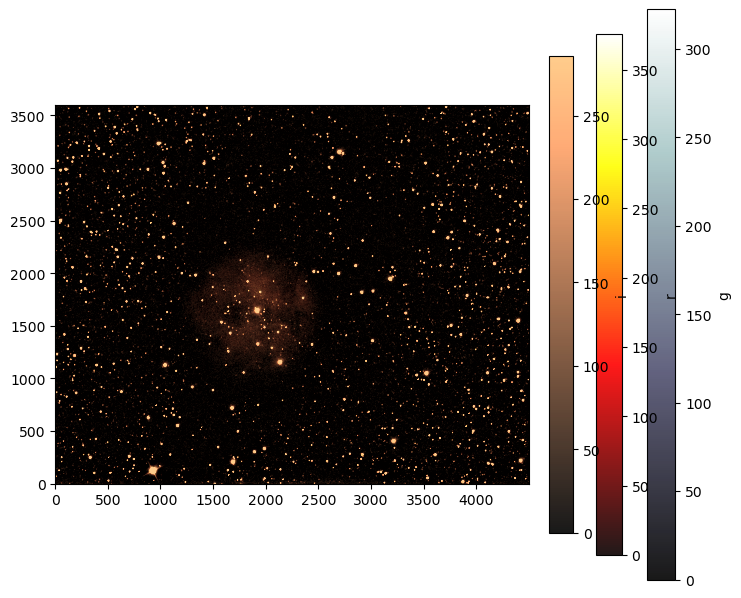

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(3):
    im1 = ax.imshow(filters[i], clim=[0,np.quantile(filters[i], [0.99])], cmap=cmaps[i], origin='lower', alpha=0.9, aspect='equal')
    # Add a single colorbar for each image
    cbar1 = plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
    cbar1.set_label(title[i])

# Show the plot
plt.show()